In [3]:
import plotly.express as px

In [4]:
import numpy as np
import math
import scipy as sp
import matplotlib.pyplot as plt
from scipy.io.wavfile import read as wavread
def ToolReadAudio(cAudioFilePath):    
    [samplerate, x] = wavread(cAudioFilePath)    
    if x.dtype == 'float32':        
        audio = x    
    else:        
        # change range to [-1,1)        
        if x.dtype == 'uint8':            
            nbits = 8        
        elif x.dtype == 'int16':            
            nbits = 16        
        elif x.dtype == 'int32':            
            nbits = 32        
        audio = x / float(2**(nbits - 1))    
        # special case of unsigned format    
    if x.dtype == 'uint8':        
        audio = audio - 1.    
    return (samplerate, audio)
def block_audio(x,blockSize,hopSize,fs):
    # allocate memory
    numBlocks = math.ceil(x.size / hopSize)
    xb = np.zeros([numBlocks, blockSize])
    # compute time stamps
    t = (np.arange(0, numBlocks) * hopSize) / fs
    x = np.concatenate((x, np.zeros(blockSize)),axis=0)
    for n in range(0, numBlocks):
        i_start = n * hopSize
        i_stop = np.min([x.size - 1, i_start + blockSize - 1])
        xb[n][np.arange(0,blockSize)] = x[np.arange(i_start, i_stop + 1)]
    return (xb,t)

In [5]:
fs=44100
test_aud = np.sin(2*np.pi*1500*np.arange(1 * fs)/fs)
test_blocked,t = block_audio(test_aud,2048, 1024, fs)
print(math.ceil(test_aud.size / 1024))

44


# A. Maximum spectral peak based pitch tracker 


- [5 points] Implement a function [X, fInHz] = compute_spectrogram(xb, fs) that computes the magnitude spectrum for each block of audio in xb (calculated using the reference block_audio() from previous assignments) and returns the magnitude spectrogram X (dimensions blockSize/2+1 X numBlocks) and a frequency vector fInHz (dim blockSize/2+1,) containing the central frequency of each bin. Do not use any third party spectrogram function. Note: remove the redundant part of the spectrum. Also note that you will have to apply a von-Hann window of appropriate length to the blocks before computing the fft. 
   
- [10 points] Implement a function: [f0, timeInSec] = track_pitch_fftmax(x, blockSize, hopSize, fs) that estimates the fundamental frequency f0 of the audio signal based on a block-wise maximum spectral peak finding approach. Note: This function should use compute_spectrogram().  
  
- [5 points] If the blockSize = 1024 for blocking, what is the exact time resolution of your pitch tracker? Can this be improved without changing the block-size? If yes, how? If no, why? (Use a sampling rate of 44100Hz for all calculations).  

## Spectrogram

In [44]:
def compute_hann(iWindowLength):
    return 0.5 - (0.5 * np.cos(2 * np.pi / iWindowLength * 
np.arange(iWindowLength)))
def compute_spectrogram(xb,fs):
    numBlocks = xb.shape[0]
    afWindow = compute_hann(xb.shape[1])
    X = np.zeros([math.ceil(xb.shape[1]/2+1), numBlocks])
    freq=np.fft.fftfreq(xb[0].size,1/fs)
    freqs = freq[:int(xb[0].size/2)+1]
    for n in range(0, numBlocks):
        # apply window
        tmp = abs(np.fft.fft(xb[n,:] * afWindow))*2/xb.shape[1]
        # freq=np.fft.fftfreq(xb[0].size,1/fs)
        # freqs[n]=freq[:int(xb[0].size/2)+1]
        # compute magnitude spectum
        X[:,n] = tmp[range(math.ceil(tmp.size/2+1))] 
        X[[0,math.ceil(tmp.size/2)],n]= X[[0,math.ceil(tmp.size/2)],n]/np.sqrt(2) 
    return X,freqs

### Testing Spectrogram

In [99]:
S,f = compute_spectrogram(test_blocked, 44100)

In [100]:
S.shape

(1025, 44)

In [101]:
f[np.argmax(S.T[0])]

1507.32421875

In [102]:
print(f)

[ 0.00000000e+00  2.15332031e+01  4.30664062e+01 ...  2.20069336e+04
  2.20284668e+04 -2.20500000e+04]


In [103]:
px.line(f)

In [104]:
def plot_spectrogram(spectrogram, fs, hopSize):
    t = hopSize*np.arange(spectrogram.shape[1])/fs
    f = np.arange(0,fs/2, fs/2/spectrogram.shape[0])

    plt.figure(figsize = (15, 7))
    plt.xlabel('Time (s)')
    plt.ylabel('Freq (Hz)')
    plt.pcolormesh(t, f, spectrogram)
    plt.show()

<ipython-input-104-3e366e55ef79>:8: MatplotlibDeprecationWarning:

shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.



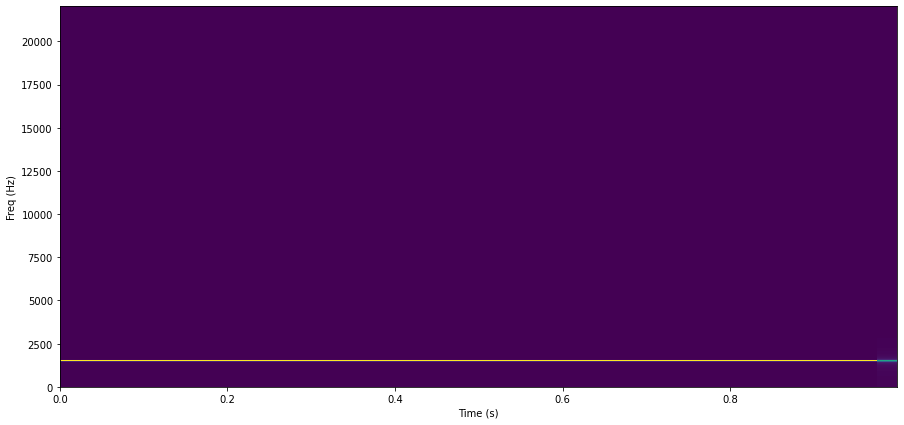

In [105]:
plot_spectrogram(S,44100,1024)

Plotting spectrum to test

In [106]:
import plotly.express as px
px.line(y=S.T[0][:-1],x=f[:-1])

## At blocksize = 1024: time resolution = 0.011609977324263039 s
Time resolution = hopSize / fs (assuming hopSize = blockSize/2, we get time resolution = blockSize/2fs)

The resolution can be adjusted by either reducing hop size, or by increasing the sample rate

In [107]:
1024/44100

0.023219954648526078

In [41]:
def block_audio(x,blockSize,hopSize,fs):
    # allocate memory
    numBlocks = math.ceil(x.size / hopSize)
    xb = np.zeros([numBlocks, blockSize])
    # compute time stamps
    t = (np.arange(0, numBlocks) * hopSize) / fs
    x = np.concatenate((x, np.zeros(blockSize)),axis=0)
    for n in range(0, numBlocks):
        i_start = n * hopSize
        i_stop = np.min([x.size - 1, i_start + blockSize - 1])
        xb[n][np.arange(0,blockSize)] = x[np.arange(i_start, i_stop + 1)]
    return (xb,t)

_,t=block_audio(test_aud,1024,512,44100)
print(t[1]-t[0])
_,t=block_audio(test_aud,2048,1024,44100)
print(t[1]-t[0])

0.011609977324263039
0.023219954648526078


## [f0, timeInSec] = track_pitch_fftmax(x, blockSize, hopSize, fs) that estimates the fundamental frequency f0 of the audio signal based on a block-wise maximum spectral peak finding approach. Note: This function should use compute_spectrogram().

In [40]:
def track_pitch_fftmax(x,blockSize,hopSize,fs):
    xb,t = block_audio(x,blockSize,hopSize,fs)
    S,f=compute_spectrogram(xb,fs)
    numBlocks = S.T.shape[0]
    f0=np.zeros(numBlocks)
    for n in range(numBlocks):
        f0[n] = f[np.argmax(S.T[n])]
    return f0,t

In [110]:
f0,t = track_pitch_fftmax(test_aud,1024,512,44100)
px.line(x=t,y=f0)

# B. HPS

In [38]:
def get_f0_from_Hps(X, fs, order):

    f_min = 50

    f = np.zeros(X.shape[1])

    # get the first order HPS
    k_length = int((X.shape[0] - 1) / order)
    HPS = X[np.arange(0, k_length), :]
#     plt.subplot(order+1,1,1)
#     plt.plot(np.arange(0,k_length),HPS[:,0])
    k_min = (np.around(f_min / fs * 2 * (X.shape[0] - 1))).astype(int)

    # compute the HPS
    for j in range(1, order):
        X_d = X[::(j + 1), :]
        HPS *= X_d[np.arange(0, k_length), :]
#         plt.subplot(order+1, 1, j+1)
#         plt.plot(np.arange(0,k_length),X_d[:k_length,1])
#     plt.subplot(order+1, 1, order+1)
#     plt.plot(np.arange(0,k_length),HPS[:,0])
    
    # find the max position of bin, convert to herz
    f = np.argmax(HPS[np.arange(k_min, HPS.shape[0])], axis=0)
    f = (f+k_min) / (X.shape[0]-1) * fs / 2

    return (f)

In [39]:
def track_pitch_hps(x, blockSize, hopSize, fs):
    xb,t = block_audio(x,blockSize,hopSize,fs)
    S,f=compute_spectrogram(xb,fs)
    numBlocks = S.T.shape[0]
    f0=np.zeros(numBlocks)
    f0 = get_f0_from_Hps(S, fs, order=4)
    return f0,t

# C. Voicing Detection

- [1 points] Take the  function [rmsDb] = extract_rms(xb) from the second assignment which takes the blocked audio as input and computes the RMS (Root Mean Square) amplitude of each block.
- [6 points] Implement a function [mask] = create_voicing_mask(rmsDb, thresholdDb) which takes a vector of decibel values for the different blocks of audio and creates a binary mask based on the threshold parameter. Note: A binary mask in this case is a simple column vector of the same size as 'rmsDb' containing 0's and 1's only. The value of the mask at an index is 0 if the rmsDb value at that index is less than 'thresholdDb' and the value is 1 if 'rmsDb' value at that index is greater than or equal to the threshold. 
- [6 points] Implement a function [f0Adj] = apply_voicing_mask(f0, mask)  which applies the voicing mask to the previously computed f0 so that the f0 of blocks with low energy is set to 0.

## Take the  function [rmsDb] = extract_rms(xb) from the second assignment which takes the blocked audio as input and computes the RMS (Root Mean Square) amplitude of each block.

In [6]:
def extract_rms(xb):
    # number of results
    numBlocks = xb.shape[0]
    # allocate memory
    vrms = np.zeros(numBlocks)
    for n in range(0, numBlocks):
        # calculate the rms
        vrms[n] = np.sqrt(np.dot(xb[n,:], xb[n,:]) / xb.shape[1])
    # convert to dB
    epsilon = 1e-5  # -100dB
    vrms[vrms < epsilon] = epsilon
    vrms = 20 * np.log10(vrms)
    return (vrms)

## [mask] = create_voicing_mask(rmsDb, thresholdDb) which takes a vector of decibel values for the different blocks of audio and creates a binary mask based on the threshold parameter.

In [7]:
def create_voicing_mask(rmsDb,thresholdDb):
    # mask = np.zeros(rmsDb.shape[0])
    f = lambda x : 1 if x > thresholdDb else 0
    return(np.array([f(x) for x in rmsDb]))

### Testing create_voicing_mask

In [8]:
rms=np.array([100,101,200,1,3,5,50])
f = lambda x : 1 if x > 30 else 0
np.array([f(x) for x in rms])

array([1, 1, 1, 0, 0, 0, 1])

In [9]:
rms=np.array([100,101,200,1,3,5,50])
thresh = 2
create_voicing_mask(rms,thresh)

array([1, 1, 1, 0, 1, 1, 1])

## [f0Adj] = apply_voicing_mask(f0, mask)  which applies the voicing mask to the previously computed f0 so that the f0 of blocks with low energy is set to 0.

In [10]:
def apply_voicing_mask(f0,mask):
    return(f0*mask)

### Testing apply_voicing_mask

In [11]:
randomLabel = np.random.randint(2, size=f0.shape[0])

NameError: name 'f0' is not defined

In [12]:
randomLabel * f0

NameError: name 'randomLabel' is not defined

# D. Different evaluation metrics
- [5 points] Implement a function [pfp] = eval_voiced_fp(estimation, annotation) that computes the percentage of false positives for your fundamental frequency estimation
False Positive : The denominator would be the number of blocks for which annotation = 0. The numerator would be how many of these blocks were classified as voiced (with a fundamental frequency not equal to 0) is your estimation. 
- [5 points] Implement a function [pfn] = eval_voiced_fn(estimation, annotation) that computes the percentage of false negatives for your fundamental frequency estimation
False Negative: In this case the denominator would be number of blocks which have non-zero fundamental frequency in the annotation. The numerator would be number of blocks out of these that were detected as zero is the estimation.
- [5 points] Now modify the eval_pitchtrack() method that you wrote in Assignment 1 to [errCentRms, pfp, pfn] = eval_pitchtrack_v2(estimation, annotation), to return all the 3 performance metrics for your fundamental frequency estimation.  Note: the errorCentRms computation might need to slightly change now considering that your estimation might also contain zeros.

## [5 points] Implement a function [pfp] = eval_voiced_fp(estimation, annotation) that computes the percentage of false positives for your fundamental frequency estimation
False Positive : The denominator would be the number of blocks for which annotation = 0. The numerator would be how many of these blocks were classified as voiced (with a fundamental frequency not equal to 0) is your estimation. 

In [13]:
def eval_voiced_fp(estimation, annotation):
    m = (annotation==0)
    denom=m.sum()
    num = ((m*estimation) > 0).sum()
    pfp = num/denom
    return pfp

### Testing eval_voiced_fp

In [14]:
est = np.array([0,1,1,0])
ann = np.array([1,0,0,0])
eval_voiced_fp(est,ann)

0.6666666666666666

## [5 points] Implement a function [pfn] = eval_voiced_fn(estimation, annotation) that computes the percentage of false negatives for your fundamental frequency estimation
False Negative: In this case the denominator would be number of blocks which have non-zero fundamental frequency in the annotation. The numerator would be number of blocks out of these that were detected as zero is the estimation.

In [15]:
def eval_voiced_fn(estimation, annotation):
    m = (annotation!=0)
    denom=m.sum()
    # Adding one to all elements in estimation so that only elements that are non-zero in annotation are set to zero in the calculation below:
    num = ((m*(estimation+1)) == 1).sum()  # counting number of elements that are non zero in annotation but 1 in annotation (after adding one to every element)
    pfn = num/denom
    return pfn

### Testing eval_voiced_fn

In [16]:
est = np.array([0,1,1,0,0])
ann = np.array([1,1,1,0,1])
eval_voiced_fn(est,ann)
# (ann!=0)*est

0.5

## [5 points] Now modify the eval_pitchtrack() method that you wrote in Assignment 1 to [errCentRms, pfp, pfn] = eval_pitchtrack_v2(estimation, annotation), to return all the 3 performance metrics for your fundamental frequency estimation.  Note: the errorCentRms computation might need to slightly change now considering that your estimation might also contain zeros.

In [29]:
def convert_freq2midi(fInHz, fA4InHz = 440):
    def convert_freq2midi_scalar(f, fA4InHz):
        if f <= 0:
            return 0
        else:
            return (69 + 12 * np.log2(f/fA4InHz))
    fInHz = np.asarray(fInHz)
    if fInHz.ndim == 0:
       return convert_freq2midi_scalar(fInHz,fA4InHz)
    midi = np.zeros(fInHz.shape)
    for k,f in enumerate(fInHz):
        midi[k] =  convert_freq2midi_scalar(f,fA4InHz)
    return (midi)

def eval_pitchtrack_v2(estimateInHz, groundtruthInHz):
    if np.abs(groundtruthInHz).sum() <= 0:
        return 0
    # truncate longer vector
    if groundtruthInHz.size < estimateInHz.size:
        estimateInHz = estimateInHz[np.arange(0,groundtruthInHz.size)]
    elif estimateInHz.size < groundtruthInHz.size:
        groundtruthInHz = groundtruthInHz[np.arange(0,estimateInHz.size)]
    #calculating rms error
    diffInCent = 100*(convert_freq2midi(estimateInHz) - convert_freq2midi(groundtruthInHz))
    rms = np.sqrt(np.mean(diffInCent[groundtruthInHz != 0]**2))
    # rms = np.sqrt(np.mean(diffInCent**2))
    pfp = eval_voiced_fp(estimateInHz,groundtruthInHz)
    pfn = eval_voiced_fn(estimateInHz, groundtruthInHz)
    return rms,pfp,pfn

### Testing eval_pitchtrack_v2

In [125]:
convert_freq2midi(est)-convert_freq2midi(ann)

array([36.37631656,  0.        ,  0.        ,  0.        , 36.37631656])

In [126]:
np.sqrt(165.0042285/5)

5.7446362548032575

In [127]:
est = np.array([440, 440, 440, 0, 440])
ann = np.array([440, 400 ,440, 0, 440])
diffInCent = 100*(convert_freq2midi(est) - convert_freq2midi(ann))
print(diffInCent)
print(diffInCent**2)
print(np.mean(diffInCent**2))
print(np.sqrt(np.mean(diffInCent**2)))
eval_pitchtrack_v2(est,ann)
# (ann!=0)*est

[  0.        165.0042285   0.          0.          0.       ]
[    0.         27226.39542285     0.             0.
     0.        ]
5445.27908457087
73.79213430014659


(73.79213430014659, 0.0, 0.0)

In [128]:
diffInCent[ann != 0]

array([  0.       , 165.0042285,   0.       ,   0.       ])

In [129]:
diffInCent

array([  0.       , 165.0042285,   0.       ,   0.       ,   0.       ])

In [130]:
ann

array([440, 400, 440,   0, 440])

# E. Evaluation
- [5 points] In a separate function executeassign3(), generate a test signal (sine wave, f = 441 Hz from 0-1 sec and f = 882 Hz from 1-2 sec), apply your track_pitch_fftmax(), (blockSize = 1024, hopSize = 512) and plot the f0 curve. Also, plot the absolute error per block and discuss the possible causes for the deviation. Repeat for track_pitch_hps() with the same signal and parameters. Why does the HPS method fail with this signal?
- [5 points] Next use (blockSize = 2048, hopSize = 512) and repeat the above experiment (only for the max spectra method). Do you see any improvement in performance? 
- [5 points] Evaluate your track_pitch_fftmax() using the development set  下载 development set(see assignment 1) and the eval_pitchtrack_v2() method (use blockSize = 1024, hopSize = 512). Report the average performance metrics across the development set.
- [5 points] Evaluate your track_pitch_hps() using the development set and the eval_pitchtrack_v2() method (use blockSize = 1024, hopSize = 512). Report the average performance metrics across the development set. 
- [6 points] Implement a MATLAB wrapper function [f0Adj, timeInSec] = track_pitch(x, blockSize, hopSize, fs, method, voicingThres) that takes audio signal ‘x’ and related paramters (fs, blockSize, hopSize), calls the appropriate pitch tracker based on the method parameter (‘acf’,‘max’, ‘hps’) to compute the fundamental frequency and then applies the voicing mask based on the threshold parameter. 
- [6 points] Evaluate your track_pitch() using the development set and the eval_pitchtrack_v2() method (use blockSize = 1024, hopSize = 512) over all 3 pitch trackers (acf, max and hps) and report the results with two values of threshold (threshold = -40, -20)

## [5 points] In a separate function executeassign3(), generate a test signal (sine wave, f = 441 Hz from 0-1 sec and f = 882 Hz from 1-2 sec), apply your track_pitch_fftmax(), (blockSize = 1024, hopSize = 512) and plot the f0 curve. Also, plot the absolute error per block and discuss the possible causes for the deviation. Repeat for track_pitch_hps() with the same signal and parameters. Why does the HPS method fail with this signal?

FFT MAX

In [131]:
def executeassign3(blockSize=1024):
    #from scipy.io import wavfile
    #fs_wav, data_wav = wavfile.read("./data/filename.wav")
    # blockSize=1024
    hopSize=int(blockSize/2)
    fs=44100

    #Generate test signal
    f1=441
    f2=882
    t=1
    samples1=np.arange(t * 44100)
    samples2=np.arange(t * 44100)
    sig_a=np.sin(2*np.pi*f1*samples1/fs)
    sig_b=np.sin(2*np.pi*f2*samples2/fs)
    test_signal=np.concatenate([sig_a,sig_b],axis=0)
    samples=np.concatenate([samples1,samples2],axis=0)

    ground_truth = np.concatenate([np.ones(44100)*441,np.zeros(1),np.ones(44099)*882],axis=0)
    #Track pitch fftmaxa

    f0_fftmax, timeInSec_fftmax = track_pitch_fftmax(test_signal, blockSize, hopSize, fs)
    indices = timeInSec_fftmax*44100
    ground_truth = [441 if i <= 44100 else 882 for i in indices]
    # error=100*(convert_freq2midi(f0_fftmax) - convert_freq2midi(ground_truth))
    error = f0_fftmax - ground_truth
    #rms,pfp,pfn=eval_pitchtrack_v2(f0_fftmax, ground_truth)
    #plt.figure(8,12)
    plt.plot(timeInSec_fftmax,f0_fftmax)
    plt.plot(timeInSec_fftmax,error)
    plt.title("Predicted f0 and error") 
    plt.xlabel("time") 
    plt.ylabel("frequency") 
    plt.legend(['f0_predicted','errorHz'])
    plt.show()

    return f0_fftmax,timeInSec_fftmax,error

HPS

In [132]:
def executeassign3hps(blockSize=1024):
    #from scipy.io import wavfile
    #fs_wav, data_wav = wavfile.read("./data/filename.wav")
    # blockSize=1024
    hopSize=int(blockSize/2)
    fs=44100

    #Generate test signal
    f1=441
    f2=882
    t=1
    samples1=np.arange(t * 44100)
    samples2=np.arange(t * 44100)
    sig_a=np.sin(2*np.pi*f1*samples1/fs)
    sig_b=np.sin(2*np.pi*f2*samples2/fs)
    test_signal=np.concatenate([sig_a,sig_b],axis=0)
    samples=np.concatenate([samples1,samples2],axis=0)

    ground_truth = np.concatenate([np.ones(44100)*441,np.zeros(1),np.ones(44099)*882],axis=0)
    #Track pitch hps

    f0_hps, timeInSec_hps = track_pitch_hps(test_signal, blockSize, hopSize, fs)
    indices = timeInSec_hps*44100
    ground_truth = [441 if i <= 44100 else 882 for i in indices]
    # error=100*(convert_freq2midi(f0_fftmax) - convert_freq2midi(ground_truth))
    error = f0_hps - ground_truth
    #rms,pfp,pfn=eval_pitchtrack_v2(f0_fftmax, ground_truth)
    #plt.figure(8,12)
    plt.plot(timeInSec_hps,f0_hps)
    plt.plot(timeInSec_hps,error)
    plt.title("Predicted f0 and error") 
    plt.xlabel("time") 
    plt.ylabel("frequency") 
    plt.legend(['f0_predicted','errorHz'])
    plt.show()

    return f0_hps,timeInSec_fftmax,error

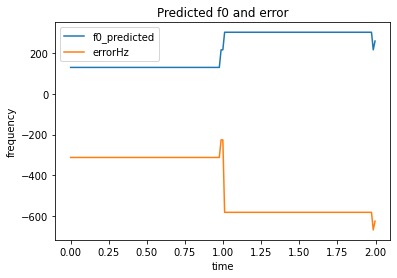

-311.80078125


In [53]:
f0_fftmax,timeInSec_fftmax,error = executeassign3hps(1024)
print(error[0])

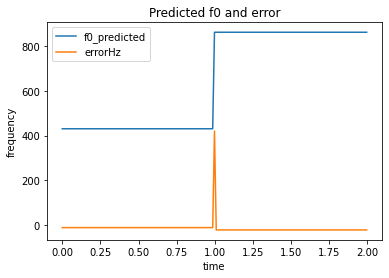

-10.3359375


In [54]:
f0_fftmax,timeInSec_fftmax,error = executeassign3(1024)
print(error[0])

## [5 points] Next use (blockSize = 2048, hopSize = 512) and repeat the above experiment (only for the max spectra method). Do you see any improvement in performance?

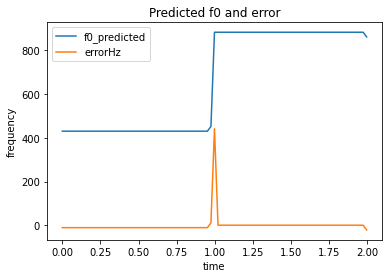

-10.3359375


In [55]:
f0_fftmax,timeInSec_fftmax,error = executeassign3(2048)
print(error[0])

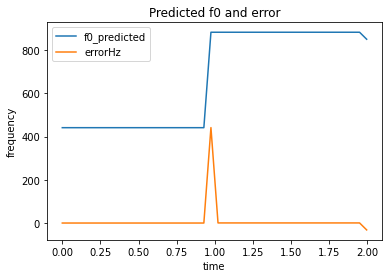

0.4306640625


In [56]:
f0_fftmax,timeInSec_fftmax,error = executeassign3(4096)
print(error[0])

## [5 points] Evaluate your track_pitch_fftmax() using the development set  下载 development set(see assignment 1) and the eval_pitchtrack_v2() method (use blockSize = 1024, hopSize = 512). Report the average performance metrics across the development set.

In [133]:
def run_evaluation (complete_path_to_data_folder):
    errorcents={}
    files=0
    errCentRms = 0
    for file_name in os.listdir(complete_path_to_data_folder):
        if file_name.endswith(".wav"):
            files = files+1
            name=file_name[:-4]
            print(name)
            #print(loc+name+'.wav')
            #print(loc+name+'.f0.Corrected.txt')
            sr,x = ToolReadAudio(complete_path_to_data_folder+name+'.wav')

            lut = np.loadtxt(complete_path_to_data_folder+name+'.f0.Corrected.txt')
            onset_seconds = lut[:,1]
            duration_seconds = lut[:,1]
            pitch_frequency = lut[:,2]
            quantized_frequency = lut[:,3]

            hopSize = np.ceil(x.shape[0]/duration_seconds.shape[0]).astype(int)
            blockSize = 2 * hopSize

            f0,ts = track_pitch_fftmax(x,blockSize,hopSize,sr)
            err,pfp,pfn = eval_pitchtrack_v2(f0,pitch_frequency)
            
            errorcents[name] = err
            errCentRms = errCentRms + (err ** 2)
    errCentRms = np.sqrt(errCentRms/files)
    return errCentRms

In [58]:
name='01-D_AMairena'
complete_path_to_data_folder='/Users/vedant/Desktop/Programming/ACA-assignments/ass3solution/trainData/'
sr,x = ToolReadAudio(complete_path_to_data_folder+name+'.wav')
xb,ts = block_audio(x,1024,512,44100)
import plotly.express as px
px.line(extract_rms(xb))

<ipython-input-11-6d08ba88c9f8>:7: WavFileWarning:

Chunk (non-data) not understood, skipping it.



File 1

In [35]:
name='01-D_AMairena'
complete_path_to_data_folder='/Users/vedant/Desktop/Programming/ACA-assignments/ass3solution/trainData/'
sr,x = ToolReadAudio(complete_path_to_data_folder+name+'.wav')
lut = np.loadtxt(complete_path_to_data_folder+name+'.f0.Corrected.txt')
duration_seconds = lut[:,1]
pitch_frequency = lut[:,2]
hopSize = np.ceil(x.shape[0]/duration_seconds.shape[0]).astype(int)
blockSize = 2 * hopSize

f0,ts = track_pitch_fftmax(x,blockSize,hopSize,sr)
err,pfp,pfn = eval_pitchtrack_v2(f0,pitch_frequency)
err

<ipython-input-1-6d08ba88c9f8>:7: WavFileWarning: Chunk (non-data) not understood, skipping it.
  [samplerate, x] = wavread(cAudioFilePath)


2124.747997174665

File 2

In [36]:
name='24-M1_AMairena-Martinete'
complete_path_to_data_folder='/Users/vedant/Desktop/Programming/ACA-assignments/ass3solution/trainData/'
sr,x = ToolReadAudio(complete_path_to_data_folder+name+'.wav')
lut = np.loadtxt(complete_path_to_data_folder+name+'.f0.Corrected.txt')
duration_seconds = lut[:,1]
pitch_frequency = lut[:,2]
hopSize = np.ceil(x.shape[0]/duration_seconds.shape[0]).astype(int)
blockSize = 2 * hopSize

f0,ts = track_pitch_fftmax(x,blockSize,hopSize,sr)
err,pfp,pfn = eval_pitchtrack_v2(f0,pitch_frequency)
err

<ipython-input-1-6d08ba88c9f8>:7: WavFileWarning: Chunk (non-data) not understood, skipping it.
  [samplerate, x] = wavread(cAudioFilePath)


2833.890936545995

File 3

In [37]:
name='63-M2_AMairena'
complete_path_to_data_folder='/Users/vedant/Desktop/Programming/ACA-assignments/ass3solution/trainData/'
sr,x = ToolReadAudio(complete_path_to_data_folder+name+'.wav')
lut = np.loadtxt(complete_path_to_data_folder+name+'.f0.Corrected.txt')
duration_seconds = lut[:,1]
pitch_frequency = lut[:,2]
hopSize = np.ceil(x.shape[0]/duration_seconds.shape[0]).astype(int)
blockSize = 2 * hopSize

f0,ts = track_pitch_fftmax(x,blockSize,hopSize,sr)
err,pfp,pfn = eval_pitchtrack_v2(f0,pitch_frequency)
err

<ipython-input-1-6d08ba88c9f8>:7: WavFileWarning: Chunk (non-data) not understood, skipping it.
  [samplerate, x] = wavread(cAudioFilePath)


2972.7315660351023

Manual RMS

In [45]:
np.sqrt(np.mean(np.array([2124.747997174665,2833.890936545995,2972.7315660351023])**2))

2669.7456093191604

### Evaluating fftmax on trainData

In [46]:
run_evaluation('/Users/vedant/Desktop/Programming/ACA-assignments/ass3solution/trainData/')

01-D_AMairena


<ipython-input-1-6d08ba88c9f8>:7: WavFileWarning: Chunk (non-data) not understood, skipping it.
  [samplerate, x] = wavread(cAudioFilePath)


24-M1_AMairena-Martinete
63-M2_AMairena


2669.7456093191604

## [6 points] Implement a MATLAB wrapper function [f0Adj, timeInSec] = track_pitch(x, blockSize, hopSize, fs, method, voicingThres) that takes audio signal ‘x’ and related paramters (fs, blockSize, hopSize), calls the appropriate pitch tracker based on the method parameter (‘acf’,‘max’, ‘hps’) to compute the fundamental frequency and then applies the voicing mask based on the threshold parameter. 

Precursor functions

In [33]:
def comp_acf(inputVector, bIsNormalized = True):
    if bIsNormalized:
        norm = np.dot(inputVector, inputVector)
    else:
        norm = 1
    afCorr = np.correlate(inputVector, inputVector, "full") / norm
    afCorr = afCorr[np.arange(inputVector.size-1, afCorr.size)]
    return (afCorr)
def get_f0_from_acf (r, fs):
    eta_min = 100
    afDeltaCorr = np.diff(r)
    eta_tmp = np.argmax(afDeltaCorr > 0)
    eta_min = np.max([eta_min, eta_tmp])
    f = np.argmax(r[np.arange(eta_min + 1, r.size)])
    f = fs / (f + eta_min + 1)
    return (f)
# def get_f0_from_acf (r, fs):
#     import scipy.signal
#     f=[]
#     p,_=scipy.signal.find_peaks(r) 
#     calculated_ts = p[np.argmax(r[p])]
#     f_calc=fs/calculated_ts
#     f.append(f_calc)
#     return np.array(f)
    
def track_pitch_acf(x,blockSize,hopSize,fs):
    # get blocks
    [xb,t] = block_audio(x,blockSize,hopSize,fs)
    # init result
    f0 = np.zeros(xb.shape[0])
    # compute acf
    for n in range(0, xb.shape[0]):
        r = comp_acf(xb[n,:])
        f0[n] = get_f0_from_acf(r,fs)
    return (f0,t)

In [23]:
f0_acf_alex,_ = track_pitch_acf(x,blockSize,hopSize,sr)

In [30]:
eval_pitchtrack_v2(f0_acf_alex, pitch_frequency)

(131.8502966207163, 1.0, 0.0)

In [34]:
name='01-D_AMairena'
complete_path_to_data_folder='/Users/vedant/Desktop/Programming/ACA-assignments/ass3solution/trainData/'
sr,x = ToolReadAudio(complete_path_to_data_folder+name+'.wav')
lut = np.loadtxt(complete_path_to_data_folder+name+'.f0.Corrected.txt')
duration_seconds = lut[:,1]
pitch_frequency = lut[:,2]
hopSize = np.ceil(x.shape[0]/duration_seconds.shape[0]).astype(int)
blockSize = 2 * hopSize

f0,ts = track_pitch_acf(x,blockSize,hopSize,sr)
err,pfp,pfn = eval_pitchtrack_v2(f0,pitch_frequency)
err

<ipython-input-4-6d08ba88c9f8>:7: WavFileWarning: Chunk (non-data) not understood, skipping it.
  [samplerate, x] = wavread(cAudioFilePath)


131.8502966207163

In [35]:
name='01-D_AMairena'
complete_path_to_data_folder='/Users/vedant/Desktop/Programming/ACA-assignments/ass3solution/trainData/'
sr,x = ToolReadAudio(complete_path_to_data_folder+name+'.wav')
lut = np.loadtxt(complete_path_to_data_folder+name+'.f0.Corrected.txt')
duration_seconds = lut[:,1]
pitch_frequency = lut[:,2]
hopSize = np.ceil(x.shape[0]/duration_seconds.shape[0]).astype(int)
blockSize = 2 * hopSize

f0,ts = track_pitch_acf(x,blockSize,hopSize,sr)
err,pfp,pfn = eval_pitchtrack_v2(f0,pitch_frequency)
err

<ipython-input-4-6d08ba88c9f8>:7: WavFileWarning: Chunk (non-data) not understood, skipping it.
  [samplerate, x] = wavread(cAudioFilePath)


131.8502966207163

In [42]:
def filter_output(f,thresh=50):
    for i, value in enumerate(f): 
        # print(i)
        if i == 0:
            # print(value)
            pass
        else:
            if f[i-1] != 0 and value!=0:
                cond1 = (np.abs(f[i] - f[i-1]) - np.abs((f[i]/2)-f[i-1]) >=thresh) and ~(np.abs((f[i]/2)-f[i-1]) - np.abs((f[i]/4)-f[i-1]) >=thresh)
                cond2 = (np.abs(f[i] - f[i-1]) - np.abs((f[i]/4)-f[i-1]) >=thresh) and (np.abs((f[i]/2)-f[i-1]) - np.abs((f[i]/4)-f[i-1]) >=thresh)
                if cond1:
                    # print("octave error")
                    # print(f'The differences are {np.abs(f[i] - f[i-1])}, {np.abs((f[i]/2)-f[i-1])} and {np.abs((f[i]/4)-f[i-1])}')
                    f[i] = value/2
                elif cond2:
                    # print("two octave error")
                    # print(f'The differences are {np.abs(f[i] - f[i-1])}, {np.abs((f[i]/2)-f[i-1])} and {np.abs((f[i]/4)-f[i-1])}')
                    f[i] = value/4
    return f
def track_pitch(x,blockSize,hopSize,fs,method,voicingThres):
    xb,t = block_audio(x,blockSize,hopSize,fs)
    # Track Pitch
    if method == 'max':
        [f0, timeInSec] = track_pitch_fftmax(x, blockSize, hopSize, fs)
    if method == 'acf':
        [f0,timeInSec] = track_pitch_acf(x, blockSize, hopSize, fs)
    if method == 'hps':
        [f0,timeInSec] = track_pitch_hps(x, blockSize, hopSize, fs)
        # [f0,timeInSec] = track_pitch_hps(x,blockSize,hopSize,fs)
    f0 = filter_output(f0,50)
    #Apply voicing mask
    rmsdB = extract_rms(xb)
    mask = create_voicing_mask(rmsdB,voicingThres)
    f0=apply_voicing_mask(f0,mask)

    return f0

In [47]:
sr,x = ToolReadAudio('/Users/vedant/Desktop/Programming/ACA-assignments/ass3solution/trainData/01-D_AMairena.wav')
f0_acf=track_pitch(x,1024,512,44100,'acf',-40)
f0_max=track_pitch(x,1024,512,44100,'max',-40)
f0_HPS=track_pitch(x,1024,512,44100,'hps',-40)

<ipython-input-4-6d08ba88c9f8>:7: WavFileWarning: Chunk (non-data) not understood, skipping it.
  [samplerate, x] = wavread(cAudioFilePath)


In [52]:
px.line(f0_max)

In [48]:
f0_acf

array([  0.        ,   0.        ,   0.        , ..., 158.63309353,
         0.        ,   0.        ])

In [49]:
f0_max

array([  0.        ,   0.        ,   0.        , ..., 473.73046875,
         0.        ,   0.        ])

In [50]:
f0_HPS

array([  0.        ,   0.        ,   0.        , ..., 301.46484375,
         0.        ,   0.        ])

In [46]:
name='01-D_AMairena'
complete_path_to_data_folder='/Users/vedant/Desktop/Programming/ACA-assignments/ass3solution/trainData/'
sr,x = ToolReadAudio(complete_path_to_data_folder+name+'.wav')
lut = np.loadtxt(complete_path_to_data_folder+name+'.f0.Corrected.txt')
duration_seconds = lut[:,1]
pitch_frequency = lut[:,2]
hopSize = np.ceil(x.shape[0]/duration_seconds.shape[0]).astype(int)
blockSize = 2 * hopSize

# FFTMAX without voicing mask
# f0,ts = track_pitch_fftmax(x,blockSize,hopSize,sr)
f0_acf=track_pitch(x,1024,512,44100,'acf',-40)
f0_max=track_pitch(x,1024,512,44100,'max',-40)
f0_hps=track_pitch(x,1024,512,44100,'hps',-40)

print(eval_pitchtrack_v2(f0_acf,pitch_frequency))

print(eval_pitchtrack_v2(f0_max,pitch_frequency))

print(eval_pitchtrack_v2(f0_hps,pitch_frequency))

<ipython-input-4-6d08ba88c9f8>:7: WavFileWarning: Chunk (non-data) not understood, skipping it.
  [samplerate, x] = wavread(cAudioFilePath)


(764.6456916713706, 0.12083333333333333, 0.0025201612903225806)
(772.1084541157957, 0.12083333333333333, 0.0030241935483870967)
(631.8289097118624, 0.12083333333333333, 0.0025201612903225806)


In [45]:
name='01-D_AMairena'
complete_path_to_data_folder='/Users/vedant/Desktop/Programming/ACA-assignments/ass3solution/trainData/'
sr,x = ToolReadAudio(complete_path_to_data_folder+name+'.wav')
lut = np.loadtxt(complete_path_to_data_folder+name+'.f0.Corrected.txt')
duration_seconds = lut[:,1]
pitch_frequency = lut[:,2]
hopSize = np.ceil(x.shape[0]/duration_seconds.shape[0]).astype(int)
blockSize = 2 * hopSize

# FFTMAX without voicing mask
# f0,ts = track_pitch_fftmax(x,blockSize,hopSize,sr)
f0_acf=track_pitch(x,1024,512,44100,'acf',-20)
f0_max=track_pitch(x,1024,512,44100,'max',-20)
f0_hps=track_pitch(x,1024,512,44100,'hps',-20)

print(eval_pitchtrack_v2(f0_acf,pitch_frequency))

print(eval_pitchtrack_v2(f0_max,pitch_frequency))

print(eval_pitchtrack_v2(f0_hps,pitch_frequency))


<ipython-input-4-6d08ba88c9f8>:7: WavFileWarning: Chunk (non-data) not understood, skipping it.
  [samplerate, x] = wavread(cAudioFilePath)


(4194.506395789744, 0.004166666666666667, 0.42086693548387094)
(4210.587466933078, 0.004166666666666667, 0.42086693548387094)
(4205.983023763337, 0.004166666666666667, 0.42086693548387094)


In [176]:
f0_hps=track_pitch(x,1024,512,44100,'hps',-20)
f0_hps[50:100]

array([ 387.59765625,  387.59765625,  387.59765625,  732.12890625,
        732.12890625,  732.12890625,  387.59765625,  387.59765625,
        387.59765625,  387.59765625, 1248.92578125,  430.6640625 ,
        430.6640625 ,  430.6640625 ,  430.6640625 ,  430.6640625 ,
       1248.92578125,  818.26171875,  818.26171875,  818.26171875,
        818.26171875, 1248.92578125, 1248.92578125, 1248.92578125,
        430.6640625 ,  430.6640625 ,  430.6640625 ,  430.6640625 ,
        430.6640625 ,  430.6640625 ,  818.26171875,  818.26171875,
        818.26171875,  818.26171875,  818.26171875,  818.26171875,
        818.26171875,  430.6640625 ,  430.6640625 ,  430.6640625 ,
        430.6640625 ,  430.6640625 ,  430.6640625 ,    0.        ,
          0.        ,  387.59765625,  387.59765625,  387.59765625,
        387.59765625,  387.59765625])

In [178]:
lut = np.loadtxt(complete_path_to_data_folder+name+'.f0.Corrected.txt')
duration_seconds = lut[:,1]
pitch_frequency = lut[:,2]

In [190]:
def filter_output(f,thresh=50):
    for i, value in enumerate(f): 
        print(i)
        if i == 0:
            print(value)
            pass
        else:
            if f[i-1] != 0 and value!=0:
                cond1 = (np.abs(f[i] - f[i-1]) - np.abs((f[i]/2)-f[i-1]) >=thresh) and ~(np.abs((f[i]/2)-f[i-1]) - np.abs((f[i]/4)-f[i-1]) >=thresh)
                cond2 = (np.abs(f[i] - f[i-1]) - np.abs((f[i]/4)-f[i-1]) >=thresh) and (np.abs((f[i]/2)-f[i-1]) - np.abs((f[i]/4)-f[i-1]) >=thresh)
                if cond1:
                    print("octave error")
                    print(f'The differences are {np.abs(f[i] - f[i-1])}, {np.abs((f[i]/2)-f[i-1])} and {np.abs((f[i]/4)-f[i-1])}')
                    f[i] = value/2
                elif cond2:
                    print("two octave error")
                    print(f'The differences are {np.abs(f[i] - f[i-1])}, {np.abs((f[i]/2)-f[i-1])} and {np.abs((f[i]/4)-f[i-1])}')
                    f[i] = value/4
    return f

In [179]:
pitch_frequency[50:100]

array([389.398, 384.093, 378.653, 372.655, 369.746, 369.2  , 370.744,
       377.787, 389.181, 402.851, 410.269, 416.793, 421.108, 419.685,
       418.648, 417.771, 417.043, 415.761, 413.248, 410.169, 410.737,
       411.707, 412.946, 414.283, 415.625, 417.187, 419.211, 418.624,
       417.165, 414.906, 411.412, 409.039, 407.471, 406.702, 406.497,
       406.849, 407.86 , 409.782, 412.516, 416.17 , 416.914, 416.161,
       414.141, 411.259, 409.324, 407.447, 404.65 , 401.597, 399.718,
       399.617])

<ipython-input-96-6d08ba88c9f8>:7: WavFileWarning:

Chunk (non-data) not understood, skipping it.



0
387.59765625
1
2
3
octave error
The differences are 344.53125, 21.533203125 and 204.5654296875
4
octave error
The differences are 366.064453125, 0.0 and 183.0322265625
5
octave error
The differences are 366.064453125, 0.0 and 183.0322265625
6
7
8
9
10
two octave error
The differences are 861.328125, 236.865234375 and 75.3662109375
11
12
13
14
15
16
two octave error
The differences are 818.26171875, 193.798828125 and 118.4326171875
17
octave error
The differences are 506.0302734375, 96.8994140625 and 107.666015625
18
octave error
The differences are 409.130859375, 0.0 and 204.5654296875
19
octave error
The differences are 409.130859375, 0.0 and 204.5654296875
20
octave error
The differences are 409.130859375, 0.0 and 204.5654296875
21
two octave error
The differences are 839.794921875, 215.33203125 and 96.8994140625
22
two octave error
The differences are 936.6943359375, 312.2314453125 and 0.0
23
two octave error
The differences are 936.6943359375, 312.2314453125 and 0.0
24
25
26
27
2

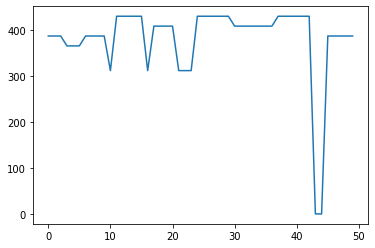

In [189]:
name='01-D_AMairena'
complete_path_to_data_folder='/Users/vedant/Desktop/Programming/ACA-assignments/ass3solution/trainData/'
sr,x = ToolReadAudio(complete_path_to_data_folder+name+'.wav')

f0_hps=track_pitch(x,1024,512,44100,'hps',-20)
f=f0_hps[50:100]

    # if i == 3:
    #     break

plt.plot(f)